In [50]:
# Got my import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import warnings
warnings.filterwarnings("ignore")

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.resnet50 import preprocess_input # Specificly for ResNet50

from keras.models import Model, Sequential
from keras import Input
from keras import callbacks
from keras.layers import Add, Input, Dense, Flatten, GlobalAveragePooling2D, LSTM, TimeDistributed
from keras.applications import ResNet50
from keras.initializers import HeNormal
from keras.optimizers import Adam
from keras.utils import plot_model

# Set Seed
from keras.utils import set_random_seed
set_random_seed(20) # Setting the random seed to keras, numpy backend generator, and random.

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version 2.12.0
Python Version: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]


In [51]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


In [52]:
MAX_PHRASE_LENGTH = 31 + 1
BATCH_SIZE = 64
LR_MAX = 1e-3
WD_RATIO = 0.05
N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
PAD_TOKEN = N_UNIQUE_CHARACTERS0 # This will be the position of Pad Token
SOS_TOKEN = N_UNIQUE_CHARACTERS0 + 1 # This will be the position of the SOS Token
EOS_TOKEN = N_UNIQUE_CHARACTERS0 + 2 # This will be the position of EOS Toekn
N_UNIQUE_CHARACTERS = N_UNIQUE_CHARACTERS0 + 3
N_TRAIN_SAMPLES = len(X_train)
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)

In [53]:
X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X.npy')
y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y.npy')[:,:MAX_PHRASE_LENGTH]
N_TRAIN_SAMPLES = len(X_train)
print(f'X_train shape: {X_train.shape}')

X_train shape: (61955, 128, 164)


In [54]:
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32

# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])

# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

In [55]:
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/input/aslfr-preprocessing-dataset/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

Found 10 Inference Pickle Files
# Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


In [56]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    """
    Returns column indices, or both column indices and names
    Input: dataframe, body_name, words/letters to exclude, get names or not, exact positions to get 
    """
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [57]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)

# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [58]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]
HAND_X_NAMES.shape, HAND_Y_NAMES.shape

((21,), (21,))

In [59]:
HAND_X_NAMES

array(['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3',
       'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7',
       'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10',
       'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13',
       'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16',
       'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19',
       'x_left_hand_20'], dtype='<U14')

In [60]:
def get_train_dataset(X, y, batch_size=64):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        # Only frames are required as model input
        inputs = X[random_sample_idxs]
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [61]:
train_dataset= get_train_dataset(X_train, y_train)

# LSTM Model:

In [62]:

callback = callbacks.EarlyStopping(monitor='train_loss', patience=3)

In [63]:
def scce_with_ls(y_true, y_pred):
    # Filter Pad Tokens
    idxs = tf.where(y_true != PAD_TOKEN)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)
    # Categorical Crossentropy with native label smoothing support
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

In [64]:
loss = scce_with_ls

In [65]:
optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

In [66]:
y_train.shape

(61955, 32)

In [67]:
# Create Initial Loss Weights All Set To 1
loss_weights = np.ones(N_UNIQUE_CHARACTERS, dtype=np.float32)

# Set Loss Weight Of Pad Token To 0
loss_weights[PAD_TOKEN] = 0

In [68]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k=1, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

In [69]:
 metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]

In [70]:
y_train[0]

array([18,  0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36, 61, 59, 59, 59, 59,
       59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59],
      dtype=int8)

In [71]:
EPOCHS = 1000

In [72]:
input_layer = Input(shape=(128, 164), name='input')
lstm_1 = LSTM(128, name='lstm_1', return_sequences=True)(input_layer)
lstm_2 = LSTM(128, name='lstm_2', return_sequences=True)(lstm_1)
lstm_3 = LSTM(128, name='lstm_3', return_sequences=True)(lstm_2)
lstm_4 = LSTM(128, name='lstm_4', return_sequences=True)(Add()([lstm_1, lstm_3]))

# Extract the desired sequence length
sliced_output = lstm_4[:, :32, :]  # Slice the output to keep only the first 31 time steps

# Dense layers
dense_1 = TimeDistributed(Dense(128, name='dense_1', activation='relu'))(sliced_output)
output = TimeDistributed(Dense(62, name='output', activation='softmax'))(dense_1)

model_lstm = Model(input_layer, output)
model_lstm.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    loss_weights=loss_weights,
)

In [73]:
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 164)]   0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128, 128)     150016      ['input[0][0]']                  
                                                                                                  
 lstm_2 (LSTM)                  (None, 128, 128)     131584      ['lstm_1[0][0]']                 
                                                                                                  
 lstm_3 (LSTM)                  (None, 128, 128)     131584      ['lstm_2[0][0]']                 
                                                                                              

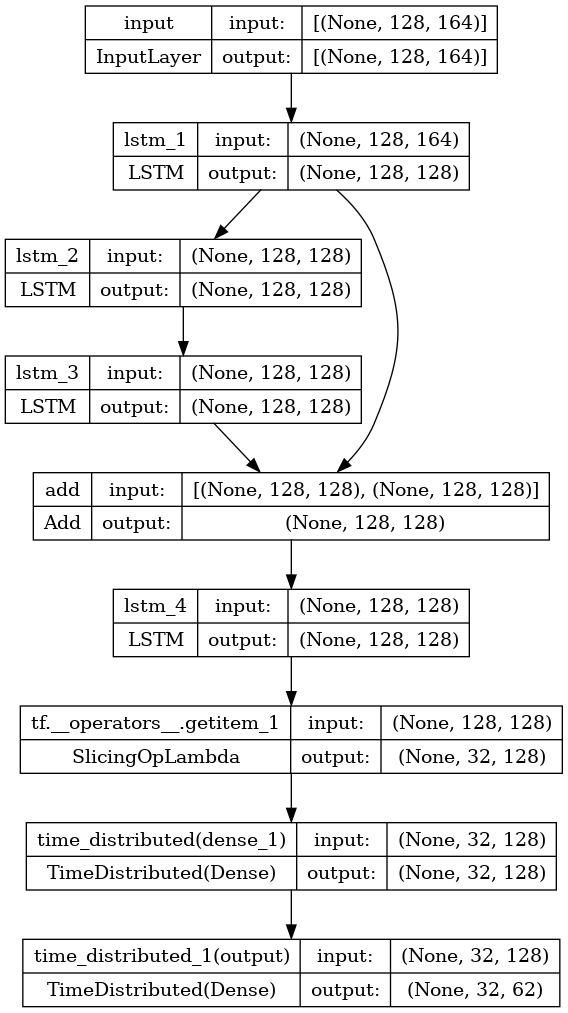

In [74]:
plot_model(model_lstm , "simple_model.png", show_shapes=True)

In [ ]:
history = model_lstm.fit(x=train_dataset, steps_per_epoch=TRAIN_STEPS_PER_EPOCH, epochs=100, verbose=True, callbacks=[callback])

In [ ]:
tf.saved_model.save(model_lstm, "LSTM_skip_2.h5")

In [ ]:
pred=model_lstm.predict(X_train[1:2])

In [ ]:
pred_c =pred.argmax(axis=2)[0]
for i in pred_c:
    print(ORD2CHAR[i])

In [ ]:
for i in y_train[1]:
    print(ORD2CHAR[i][])

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load image from file
image = Image.open("/kaggle/working/simple_model.png")

# Convert image to a NumPy array
image_data = np.array(image)

image_data = image_data.astype(float)

plt.imshow(image_data)
plt.show()